In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pyMRAW
import pyidi

%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\kristofc\Doktorat\Projekti\pyidi\.venv\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 150000, Original total frame: 621319)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


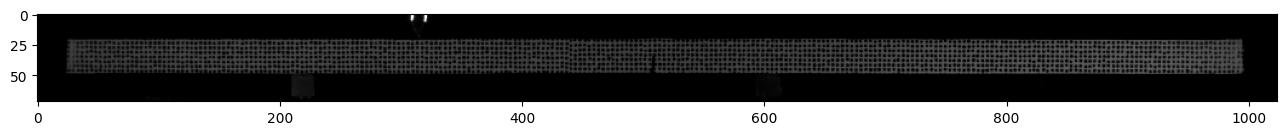

In [2]:
file = "C:\\Users\\kristofc\\Doktorat\\Podatki\\20201011_Nosilec_zareza_speckle\\video_001.cihx"

video = pyMRAW.load_video(file)
cih = video[1]
cih

plt.rcParams['figure.figsize'] = (16,6)

fig = video[0][0]#[:150000,:,25:995]

plt.imshow(fig, 'gray')

In [3]:
vect_0 = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\vect_0.txt")
vect_1 = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\vect_1.txt")
coord  = np.loadtxt("C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek I\\Python Nosilec\\coord.txt")

# coord[:,[0,1]] = coord[:,[1,0]]

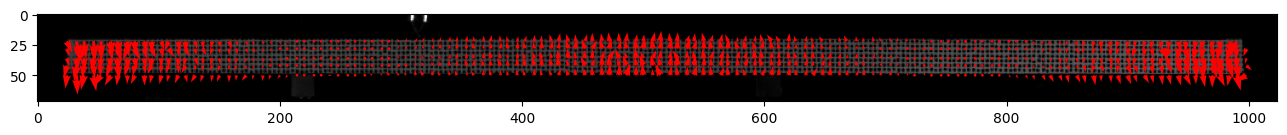

In [4]:
mode_0 = vect_0[0,:]
mode_1 = vect_1[0,:]

disp = np.column_stack((mode_0, mode_1))

plt.imshow(fig, 'gray')
# plt.scatter(coord[:,1], coord[:,0])
plt.quiver(coord[:,1], coord[:,0], mode_1, mode_0, color = 'r', scale = 1.1)

In [17]:
vid = pyidi.pyIDI(file)
vid.set_points(points=coord)

res = pyidi.postprocessing.mode_shape_magnification(video = vid, 
                                                displacements = disp, 
                                                magnification_factor = 500,
                                                background_brightness = 1,
                                                show_undeformed=False)

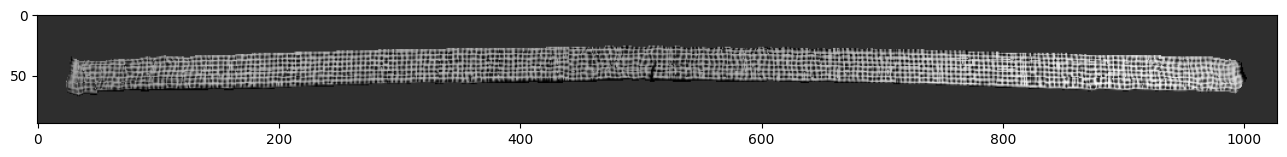

In [18]:
plt.imshow(res, 'gray')

In [29]:
# pyidi.postprocessing.animate(video = vid,
#                              displacements = disp,
#                              magnification_factor = 500,
#                              fps = 30,
#                              n_periods = 5,
#                              filename = 'my_folder/my_video',
#                              output_format = 'mp4',
#                              background_brightness = 0.2)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1240, 114) to (1248, 128) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved in file: my_folder/my_video.mp4
